In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem, MACCSkeys

In [2]:
train = pd.read_csv('../../data/lo/kcnh2/train_1.csv')
test = pd.read_csv('../../data/lo/kcnh2/test_1.csv')

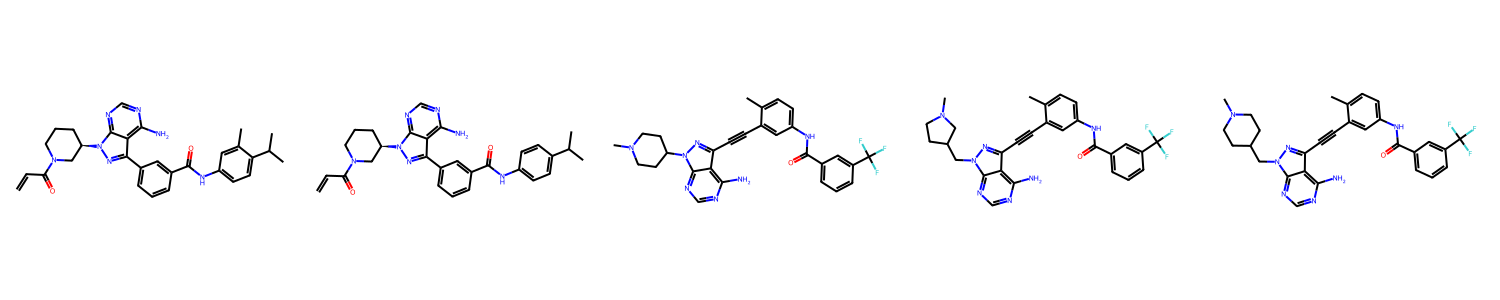

In [3]:
smiles = test[test['cluster'] == 1]['smiles'].to_list()
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles]
img = Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(300, 300))
img

In [4]:
import sys
sys.path.append('../../code')

from splits import get_nearest_mols

In [5]:
from rdkit import Chem, DataStructs

lhs_mols = []
for smiles in test['smiles']:
    lhs_mols.append(Chem.MolFromSmiles(smiles))
lhs_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2, 1024) for x in lhs_mols]

rhs_mols = []
for smiles in train['smiles']:
    rhs_mols.append(Chem.MolFromSmiles(smiles))
rhs_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2, 1024) for x in rhs_mols]

nearest_dist = []
nearest_idx = []
for lhs in lhs_fps:
    sims = DataStructs.BulkTanimotoSimilarity(lhs, rhs_fps)
    nearest_dist.append(sims)
    nearest_idx.append(np.argmax(sims))

In [6]:
nearest_dist = np.stack(nearest_dist)

In [7]:
max_cluster = test['cluster'].max()
for i in range(1, max_cluster):
    cluster_idx = np.where(test['cluster'] == i)[0]
    distances = nearest_dist[cluster_idx]
    is_near = distances > 0.40
    each_has = True
    only_one = True
    if not np.all(is_near.sum(axis=1) == 1):  # each molecule in cluster have only one similar molecule in the train
        each_has = False

    if not len(np.unique(np.where(is_near)[1])) == 1:  # it is the same molecule for the whole cluster
        only_one = True
    if not each_has or not only_one:
        print(i, each_has, only_one)

In [4]:
def calculate_per_cluster_diversity(data, is_morgan):
    smiles = data['smiles']
    mols = [Chem.MolFromSmiles(x) for x in smiles]
    if is_morgan:
        fps_vec = [AllChem.GetMorganFingerprintAsBitVect(x, 2, 1024) for x in mols]
    else:
        fps_vec = [Chem.MACCSkeys.GenMACCSKeys(x) for x in mols]

    fps = [vec.ToList() for vec in fps_vec]
    string_fps = []
    for vec in fps:
        sub_vec = [str(x) for x in vec]
        string_fps.append(''.join(sub_vec))
    string_fps = np.array(string_fps)

    different_fps_per_cluster = []

    for cluster_idx in data['cluster'].unique():
        idx = data['cluster'] == cluster_idx
        cluster_fps = set(string_fps[idx])
        different_fps_per_cluster.append(len(cluster_fps))
    return different_fps_per_cluster

In [5]:
train_1 = pd.read_csv('../../data/lo/kcnh2/train_1.csv')
test_1 = pd.read_csv('../../data/lo/kcnh2/test_1.csv')

train_2 = pd.read_csv('../../data/lo/kcnh2/train_2.csv')
test_2 = pd.read_csv('../../data/lo/kcnh2/test_2.csv')

train_3 = pd.read_csv('../../data/lo/kcnh2/train_3.csv')
test_3 = pd.read_csv('../../data/lo/kcnh2/test_3.csv')

(array([ 2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., 72.]),
 array([3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 10 artists>)

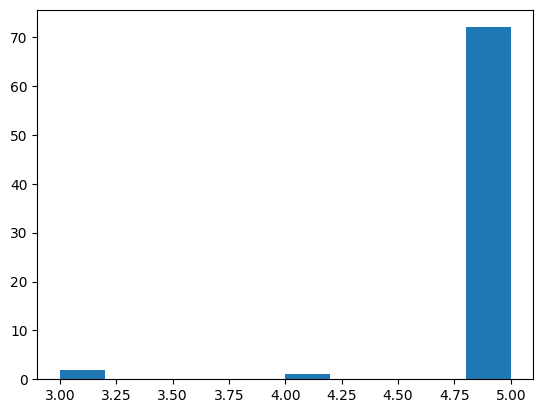

In [6]:
plt.hist(calculate_per_cluster_diversity(test_1, True))

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0., 71.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <BarContainer object of 10 artists>)

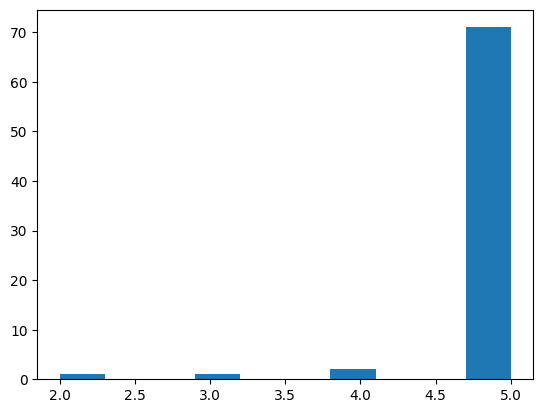

In [7]:
plt.hist(calculate_per_cluster_diversity(test_2, True))

(array([ 2.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0., 70.]),
 array([3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 10 artists>)

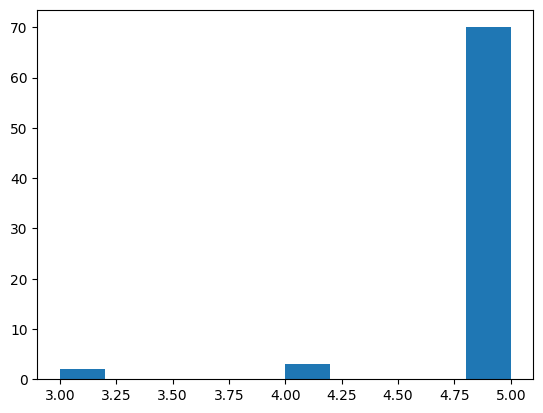

In [8]:
plt.hist(calculate_per_cluster_diversity(test_3, True))

(array([ 1.,  0.,  1.,  0.,  0.,  4.,  0., 18.,  0., 51.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

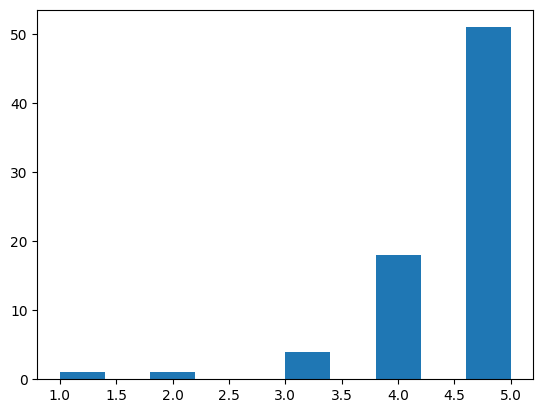

In [9]:
plt.hist(calculate_per_cluster_diversity(test_1, False))

(array([ 1.,  0.,  1.,  0.,  0.,  3.,  0., 19.,  0., 51.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

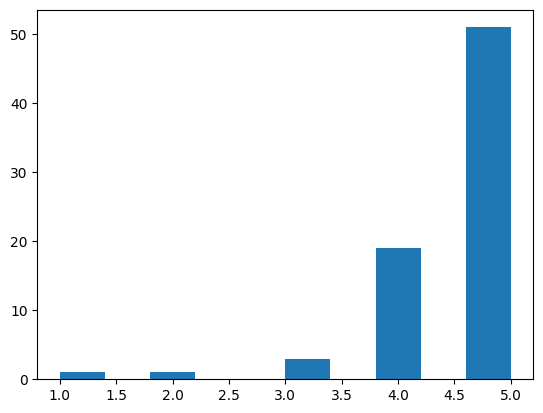

In [10]:
plt.hist(calculate_per_cluster_diversity(test_2, False))

(array([ 1.,  0.,  0.,  0.,  0.,  5.,  0., 17.,  0., 52.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

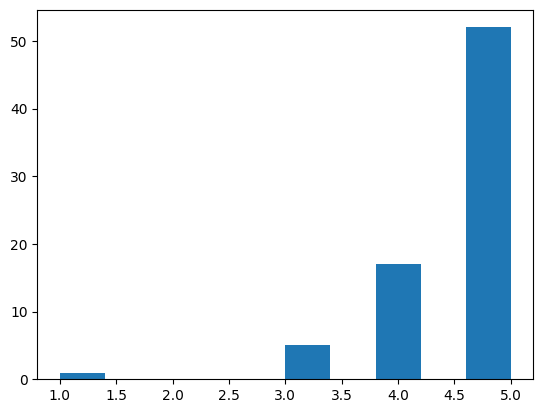

In [11]:
plt.hist(calculate_per_cluster_diversity(test_3, False))